## Projet

La société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. 
Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).


## Mission

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.


### *Préparation des données*

Il est fortement conseillé de sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Ce kernel sera analysé et adapteré pour vous assurer qu’il répond aux besoins de la mission.

# A) Exploration des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Le dossier contient 10 fichiers csv, dont 1 fichier de description des colonnes de chaque fichier :

#### application_train.csv  & application_test.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).

Static data for all applications. One row represents one loan in our data sample.

In [2]:
df = pd.read_csv('application_train.csv', sep=',')
df.sample(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
84632,198189,0,Cash loans,F,N,Y,0,112500.0,462195.0,23728.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
67799,178628,0,Cash loans,F,N,Y,0,49500.0,76410.0,7956.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Visualisation de la répartition des valeurs de la variable *'TARGET'* :

Information provenant du fichier csv *HomeCredit_columns_description*:
"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"

In [3]:
df['TARGET'].isna().sum()

0

Text(0.5, 1.0, 'Répartition TARGET')

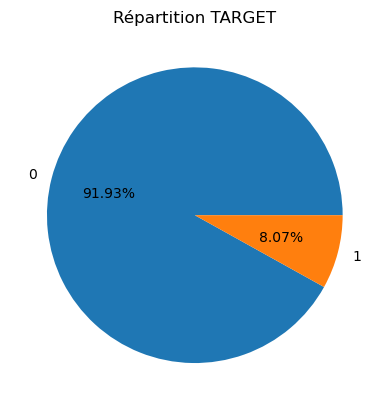

In [4]:
plt.axis('off')
df.TARGET.value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Répartition TARGET')

Déséquilibre clair du nombre de clients dont la demande de prêt a été acceptée (0 - 91.93%) et ceux à qui elle a été refusée (1 - 8.07%).

In [5]:
test_df = pd.read_csv('application_test.csv', sep=',')
test_df.sample(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
28996,311327,Cash loans,F,Y,N,0,157500.0,360000.0,22153.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
13366,196985,Cash loans,M,N,Y,0,202500.0,248760.0,29520.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


Seul le fichier application_train.csv contient les classes (TARGET), il servira de base aux traitements à réaliser. 

Le fichier application_test.csv ne contient pas les classes car il est utilisé pour réaliser une prédiction à l’aveugle à soumettre à Kaggle, il ne sera pas exploitable pour entraîner un modèle

#### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [6]:
bureau = pd.read_csv('bureau.csv', sep=',')
bureau.sample(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
40852,274798,5210697,Closed,currency 1,-2213,0,-2001.0,-2015.0,9450.0,0,48512.79,0.0,0.0,0.0,Consumer credit,-2000,NaN
1449579,187547,5777860,Closed,currency 1,-2475,0,-2107.0,-2106.0,0.0,0,42750.00,0.0,0.0,0.0,Consumer credit,-2097,NaN


#### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [7]:
bb = pd.read_csv('bureau_balance.csv', sep=',')
bb.sample(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
7471445,6092064,-77,C
15006648,6359297,-4,X


#### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.

In [8]:
prev = pd.read_csv('previous_application.csv', sep=',')
prev.sample(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1249305,1402533,119102,Cash loans,14509.98,135000.0,143910.0,NaN,135000.0,TUESDAY,14,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
1444840,1368802,195909,Cash loans,3684.60,45000.0,50940.0,NaN,45000.0,MONDAY,14,...,XNA,24.0,high,Cash X-Sell: high,365243.0,-890.0,-200.0,-230.0,-228.0,1.0


#### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [9]:
pos = pd.read_csv('POS_CASH_balance.csv', sep=',')
pos.sample(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3957406,2581519,436905,-72,10.0,8.0,Active,0,0
2947995,2288520,143961,-24,10.0,7.0,Active,0,0


#### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [10]:
ins = pd.read_csv('installments_payments.csv', sep=',')
ins.sample(2)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
6762171,2825064,291198,1.0,17,-323.0,-336.0,27926.595,27926.595
1460102,1647369,151808,1.0,1,-54.0,-66.0,37801.845,37801.845


#### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [11]:
cc = pd.read_csv('credit_card_balance.csv', sep=',')
cc.sample(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3816540,1316606,165989,-5,0.0,180000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
398230,1208643,158209,-54,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,29.0,Active,0,0


In [12]:
print('shape df: ', df.shape)
print('shape test_df: ', test_df.shape)
print('shape bureau: ', bureau.shape)
print('shape bb: ', bb.shape)
print('shape prev: ', prev.shape)
print('shape pos: ', pos.shape)
print('shape ins: ', ins.shape)
print('shape cc: ', cc.shape)

shape df:  (307511, 122)
shape test_df:  (48744, 121)
shape bureau:  (1716428, 17)
shape bb:  (27299925, 3)
shape prev:  (1670214, 37)
shape pos:  (10001358, 8)
shape ins:  (13605401, 8)
shape cc:  (3840312, 23)


# B) Pré-traitement des données

Utilisation du Kernel Kaggle *'LightGBM with Simple Features'*, dont le feature engineering est performant, pour la préparation des données nécessaires à l’élaboration du modèle de scoring.
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

#### 1° création des fonctions communes

In [13]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import gc
import time
import re
from contextlib import contextmanager

# Un gestionnaire de contexte est utilisé pour créer et nettoyer correctement les ressources requises par le programme.
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# assignation de numéro de catégories pour les colonnes contenant des objets(dtype='object')
# One-hot encoding for categorical columns with get_dummies. Nans are note ignored (nan_as_category = True)
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # get_dummies(dummy_na) -> bool, default False: Add a column to indicate NaNs, if False NaNs are ignored
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#### 2° création des fonctions de traitement par groupes de fichiers ou par fichier csv:

In [14]:
# Preprocess application_train.csv 
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))  # affichage du nombre de lignes par df
    # Optional: Supprimer 4 applications qui ont pour valeur XNA dans la variable 'CODE_GENDER' (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encode'CODE_GENDER' manually
    df['CODE_GENDER'] = df['CODE_GENDER'].map({'F': 1, 'M': 0})
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        # pd.factorize : Encode the object as an enumerated type or categorical variable
        df[bin_feature], uniques = pd.factorize(df[bin_feature])  
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

In [15]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()  # Force un garbage collection
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()  
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [16]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [17]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [18]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [19]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

#### 3° Création du dataframe final *df* en joignant les différents dataframes

In [20]:
# join the dataframes together
def principal(debug = False):   # debug=false is is for deployment to a production server
    num_rows = 10000 if debug else None
    df = application_train(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Rename columns"):
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df
df = principal()
df.shape

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 25s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 34s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 23s
Rename columns - done in 5s


(307507, 797)

In [21]:
# Suppression de toutes les variables ayant des taux de remplissage inférieur à 80%.
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
columns_to_keep = missing_value_df[missing_value_df['percent_missing'] < 20]
list_columns = columns_to_keep['column_name'].to_list()
df = df[list_columns]
df.shape

(307507, 508)

In [22]:
# Vérification des différents dtypes du dataframe
df.dtypes.value_counts()

float64    332
uint8      133
int64       43
dtype: int64

In [23]:
# Analyse des valeurs infinies
count = np.isinf(df).values.sum()
print("The dataframe contains " + str(count) + " infinite values.")

The dataframe contains 19 infinite values.


In [24]:
# Suppression des valeurs infinies (infinite values)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
count = np.isinf(df).values.sum()
print("The dataframe contains " + str(count) + " infinite values.")

The dataframe contains 0 infinite values.


In [25]:
# traitement des données manquantes avec la médiane par colonne grâce à simpleimputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(df)
df = pd.DataFrame(imputer.transform(df.loc[:,:]), columns = df.columns)

Enregistrement du dataframe pour utilisation dans la suite du notebook

In [26]:
df_final = df.copy()
df_final = df_final.sort_values(by=['SK_ID_CURR'])
df_final.to_csv(r'C:\Users\Florent\Documents\Data_Formation\Projet_7\df_final.csv', index=False)

In [27]:
application_train_sorted = pd.read_csv('application_train.csv', sep=',')
application_train_sorted = application_train_sorted.sort_values(by=['SK_ID_CURR'])
application_train_sorted['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
application_train_sorted.to_csv(r'C:\Users\Florent\Documents\Data_Formation\Projet_7\application_train_sorted.csv', index=False)